In [29]:
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.sparse import csr_matrix, hstack

from sklearn.base import clone
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from openai import OpenAI


## Exploratory Analysis

#### Load and Examine Data

In [2]:
# Read uru csv
urdu_csv_path = 'Roman Urdu DataSet.csv'
urdu_orig_df = pd.read_csv(urdu_csv_path, header=None)

# Copy original and name the fields
urdu_df = urdu_orig_df.copy(deep=True)

# Data has a 3rd column of almost entirely null values. 
print(urdu_df.shape)
print(urdu_df.head(10))

(20229, 3)
                                                   0         1    2
0  Sai kha ya her kisi kay bus ki bat nhi hai lak...  Positive  NaN
1                                          sahi bt h  Positive  NaN
2                                        Kya bt hai,  Positive  NaN
3                                         Wah je wah  Positive  NaN
4                               Are wha kaya bat hai  Positive  NaN
5                                 Wah kya baat likhi  Positive  NaN
6                              Wha Itni sari khubiya  Positive  NaN
7                                       Itni khubiya  Positive  NaN
8  Ya allah rehm farma hm sab pe or zalimo ko hid...  Positive  NaN
9  Please Everyone AllAh S.w.T ka naam hAmesha Ba...  Positive  NaN


#### Identify Data Cleaning Tasks

In [3]:
# The text field has English and blanks in addition to Roman Urdu.
print(urdu_df[0].value_counts(dropna=False).head(20))


Good                           23
<3 CH ADNAN ANSAR GUJJAR <3    18
:D                             18
Nice                           17
Hahaha                         15
Shikra                         12
                               11
Beshak                         10
Haha                           10
                                9
Right                           9
                                8
good                            8
0                               8
                                7
Ameen                           7
                                7
Hahahaha                        7
Hahahahaha                      6
Zabardast                       6
Name: 0, dtype: int64


In [4]:
# The text field has 112 rows that are null or contain only blanks, all have a ‘Neutral’ sentiment
print("\nSentiment values of blanks:\n", urdu_df[urdu_df[0].fillna('').str.isspace()][1].value_counts(dropna=False), sep='')



Sentiment values of blanks:
Neutral    112
Name: 1, dtype: int64


In [5]:
# The ‘sentiment’ field has more than the expected the three expected sentiment values.
urdu_df[1].value_counts(dropna=False)

Neutral     8929
Positive    6013
Negative    5286
Neative        1
Name: 1, dtype: int64

In [6]:
# The 3rd column is 99.96% null. 
urdu_df[2].value_counts(normalize=True, dropna=False).head(20)

NaN                 0.999654
till here           0.000099
----------------    0.000049
----------          0.000049
-------             0.000049
------              0.000049
9090                0.000049
Name: 2, dtype: float64

## Data Cleaning:
* Drop the 3rd column
* Select field name for each column. 
* Use regex to steamline common sentiment variations.
* Streamline all text whitespace, blank rows, and new line characters.
* Remove duplicates and print final shape

In [7]:
# Drop the 3rd column
urdu_df = urdu_df.iloc[:,:2]

# Select field name for each column
urdu_df.columns = ["text","sentiment"]

In [8]:
# Before applying regex replacements, display the value counts
print("\t   Before:\n",urdu_df['sentiment'].value_counts(dropna=False), sep='')

# Use regex to steamline common sentiment variations
urdu_df['sentiment'] = urdu_df['sentiment'].str.replace(r'^p.*', 'Positive', regex=True, flags=re.IGNORECASE)
urdu_df['sentiment'] = urdu_df['sentiment'].str.replace(r'^n.*l$', 'Neutral', regex=True, flags=re.IGNORECASE)
urdu_df['sentiment'] = urdu_df['sentiment'].str.replace(r'^n.*e$', 'Negative', regex=True, flags=re.IGNORECASE)

# Display the value counts after regex replacements
print("\n\n\t   After:\n",urdu_df['sentiment'].value_counts(dropna=False), sep='')

	   Before:
Neutral     8929
Positive    6013
Negative    5286
Neative        1
Name: sentiment, dtype: int64


	   After:
Neutral     8929
Positive    6013
Negative    5287
Name: sentiment, dtype: int64


In [9]:
# Before consolidating blanks and empty values, display the value counts
print("\t\tBefore:\n", urdu_df['text'].value_counts(dropna=False).head(10), sep='')

# Remove line breaks
urdu_df['text'] = urdu_df['text'].str.replace('\n', ' ', regex=True)

# Consolidate blanks and empty values 
urdu_df.loc[urdu_df['text'].fillna('').str.isspace(), 'text'] = ""
urdu_df['text'] = urdu_df['text'].fillna('')

# Display the value counts after consolidation
print("\n\n\t\tAfter:\n", urdu_df['text'].value_counts(dropna=False).head(10), sep='')

		Before:
Good                           23
<3 CH ADNAN ANSAR GUJJAR <3    18
:D                             18
Nice                           17
Hahaha                         15
Shikra                         12
                               11
Beshak                         10
Haha                           10
                                9
Name: text, dtype: int64


		After:
                               113
Good                            23
:D                              18
<3 CH ADNAN ANSAR GUJJAR <3     18
Nice                            17
Hahaha                          15
Shikra                          12
Haha                            10
Beshak                          10
Right                            9
Name: text, dtype: int64


In [10]:
# Remove duplicates
urdu_df = urdu_df.drop_duplicates()

# Display the shape of the DataFrame after removing duplicates
print("urdu_df shape:")
print(urdu_df.shape)

urdu_df shape:
(19648, 2)


## Use the Openai package to identify the dominant language in each row

#### Define the necessary openai API functions

In [11]:
# Set a OPEN_AI_KEY variable to one of your openai API keys
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY")) 


def get_response(df_batch, model="gpt-3.5-turbo",
                 doc_col = 'text',
                 intro_context = "Classify the dominant language for each of the following texts:",
                 outro_context = "The acceptable responses for each row are 'Roman Urdu' or 'English'. If unsure, pick 'Roman Urdu'."):
    """
    Function to classify dominant language.
    Requires custom logic into the OpenAI model.

    Args:
        df_batch (pd.DataFrame): A batch of data containing text to classify.
        model (str): The OpenAI model to use.

    Returns:
        OpenAIResponse: The response object from the OpenAI API.
    """
    
    # Wrap the prompt text in context clarifying the question for chatGPT
    prompt_batch = '\n'.join([f"{i}. [{text}]" for i, text in df_batch[doc_col].items()])
    message_batch = [
                {"role": "user", "content": intro_context},
                {"role": "user", "content": prompt_batch},
                {"role": "user", "content": outro_context}
    ]
    
    # Request the response from the chatGPT API
    response = client.chat.completions.create(
        model=model,
        messages=message_batch,
        temperature=0.0, 
        max_tokens = 2000 
    )
    
    return response

def process_rows(df, indices, output_column = 'language'):
    """ 
    Process a batch of rows from the DataFrame to identify the dominant language.
    
    Args:
        df (pd.DataFrame): The DataFrame containing text data.
        indices (list): List of indices of rows to be processed.

    Returns:
        pd.DataFrame: The DataFrame with updated language classifications.
    """
    
    if len(indices) == 0:
        return df
    
    else:
        df_batch = df.loc[indices].copy(deep=True)
        
        # Get responses from OpenAI
        response = get_response(df_batch)

        # Extract and populate the mapping dictionary
        mapping = {}
        response_text = response.choices[0].message.content
        lines = response_text.split('\n')
        for line in lines:
            parts = line.split('. ', 1)
            if len(parts) == 2:
                number, text = parts
                try:
                    mapping[int(number)] = text
                except ValueError as e:
                    print(f"An error occurred: {e}")
                    print(f"\nnumber failed to convert: {number}")
                    print(f"\ntext: {text}")
                
        # Map the 'language' column
        df.loc[df_batch.index, output_column] = df_batch.index.map(mapping)
        try:
            df[output_column] = df[output_column].str.strip()
        except AttributeError as a:
            print(f"An error occurred: {a}")
            print(f"\ndf[output_column].str.strip() failed:")
            print(f"\ndf[output_column].unique(): {df[output_column].unique()}")
        
        return df
    
def process_dataframe_in_batches(df, batch_size):
    """
    Process a DataFrame in batches using the process_rows() function.

    Args:
        df (pd.DataFrame): The DataFrame to be processed.
        batch_size (int): The size of each batch.

    Returns:
        pd.DataFrame: The processed DataFrame.

    Example:
        processed_df = process_dataframe_in_batches(urdu_df_lang, 10)
    """
    
    # Designate the number of batches
    num_batches = len(df) // batch_size + 1
    
    # Loop each batch through process_rows()
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(df))
        batch_indices = list(df.index[start_idx:end_idx])
        
        df = process_rows(df, batch_indices)
    
    return df

##### Initial run to obtain the dominant language for each row

In [12]:
# Create a deep copy of urdu_df
urdu_df_lang = urdu_df.copy(deep=True)

# Define the batch size
batch_size = 10

# Process the DataFrame in batches to obtain the dominant language for each row
urdu_df_lang = process_dataframe_in_batches(urdu_df_lang, batch_size)
urdu_df_lang.language.value_counts(dropna=False)


Roman Urdu                                                    18754
English                                                         758
NaN                                                             116
Urdu                                                             14
Arabic                                                            2
Unable to classify without text                                   1
Spanish                                                           1
Unable to classify as it contains only symbols and spaces.        1
Hindi                                                             1
Name: language, dtype: int64

##### Loop straggling nulls through the openai API a few more times

In [13]:
# Initialize variables
max_runs = 3
current_run = 0
rerun_mask = (urdu_df_lang['language'] != "Roman Urdu") & (urdu_df_lang['language'] != "English") #urdu_df_lang['language'].isnull()
urdu_df_lang_filtered = urdu_df_lang.loc[rerun_mask].copy(deep=True)

while not urdu_df_lang_filtered.empty and current_run < max_runs:
    
    # Process null values through the OpenAI API
    urdu_df_lang_filtered = process_dataframe_in_batches(urdu_df_lang_filtered, batch_size)
        
    # update the dataframes, the rerun_mask, and the current_run 
    urdu_df_lang.loc[rerun_mask, ['language']] = urdu_df_lang_filtered.loc[:, ['language']].copy(deep=True)
    rerun_mask = (urdu_df_lang['language'] != "Roman Urdu") & (urdu_df_lang['language'] != "English")
    urdu_df_lang_filtered = urdu_df_lang.loc[rerun_mask].copy(deep=True)
    current_run += 1
    print(f"Value counts after run {current_run}:\n\n{urdu_df_lang['language'].value_counts(dropna=False)}\n\n")

Value counts after run 1:

Roman Urdu    18840
English         777
NaN              30
Spanish           1
Name: language, dtype: int64


Value counts after run 2:

Roman Urdu    18840
English         777
NaN              31
Name: language, dtype: int64


Value counts after run 3:

Roman Urdu    18840
English         777
NaN              31
Name: language, dtype: int64




In [14]:
# View any remaining straggler rows
print(urdu_df_lang_filtered)

                                                   text sentiment language
1972  jo apni makhsoos tarz-e-mazah aur do maeyne gu...  Positive      NaN
1973   Ashfaq Ahmed apne dramon mein plot se ziyada ...  Positive      NaN
1974   Urdu ke do naamwar adeeb Mumtaz Mufti aur Qud...  Positive      NaN
1975   Raja gidh novel ki khaliq Bano Qudsiya Urdu k...  Positive      NaN
1976   Ek munfarid afsana nigar, ek be-badal nasar n...  Positive      NaN
1977  Urdu adab ke bohat se naqadeen ke nazdeek Faiz...  Positive      NaN
1978               Ap ke walid aik ilm pasand aadmi the  Positive      NaN
1979   Aap ke usatzaa mein Mir Maulvi Shams ul Haq (...  Positive      NaN
1980   1947 se 1958 ke darmiyan aap mukhtalif adbi r...  Positive      NaN
1981           Ap ko 2 April 1955 ko riha kar diya gaya  Positive      NaN
1992  pehla resala 1933 mein Chaudhry Rehmat Ali ne ...  Positive      NaN
1993  Hindustan mein haft Roza “Pakistan” June 1936 ...  Positive      NaN
1994  1937 mein Punjab ke

#### Print the final dominant language count

In [15]:
print(f"{urdu_df_lang['language'].value_counts(dropna=False)}")

Roman Urdu    18840
English         777
NaN              31
Name: language, dtype: int64


In [16]:
# Optionally save a backup copy of API data
# urdu_df_lang.to_csv('urdu_df_lang.csv', index=False)

## Additional Wrangling

#### Filter to only Roman Urdu rows for processing

In [17]:
urdu_df_lang = urdu_df_lang[urdu_df_lang['language'] == "Roman Urdu"]

#### Generate length column and examine counts

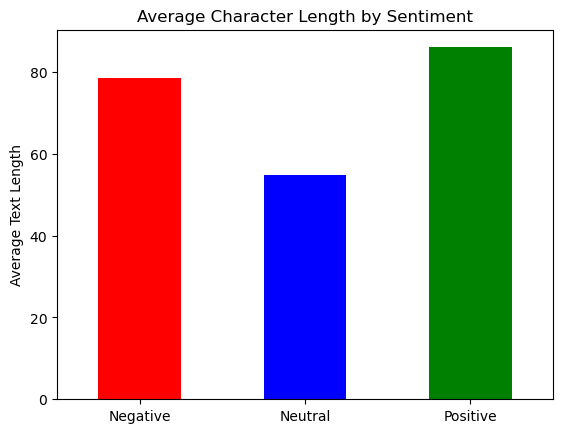

In [18]:
# Calculate and fill the 'length' column with the text character lengths
urdu_df_lang['length'] = urdu_df_lang['text'].str.len().fillna(0)

# Calculate the average character length for each sentiment and graph it
average_lengths = urdu_df_lang.groupby('sentiment')['length'].mean()
average_lengths.plot(kind='bar', title='Average Character Length by Sentiment', xlabel='', ylabel='Average Text Length', rot=0, color=['r', 'b', 'g'])
average_lengths

# Calculate alternative 'Negative' target label column
urdu_df['Negative'] = (urdu_df['sentiment'] == 'Negative').astype(int)



#### Initialize Data Processing Variables

In [19]:
# Create a TfidfVectorizer to convert text into numerical features
vectorizer = TfidfVectorizer(dtype=np.float32, ngram_range = (1,2), min_df=2) # Could also introduce as a Pipeline() step

# Initialize Scaler
scaler = StandardScaler()

# Additional column features
extra_features = ['length']

# Identify Target Label
y_col = 'sentiment'

#### Split and process the training and test sets for prediction

In [20]:
# Split Data for Classification of Sentiment
X_train, X_test, y_train, y_test = train_test_split(urdu_df_lang[['text'] + extra_features], urdu_df_lang[y_col], test_size=0.2, random_state=42)

In [21]:
# Fit and Transform X_train 
X_train_tfidf_features = vectorizer.fit_transform(X_train['text']) # fit and transform
X_train_length_column = scaler.fit_transform(np.array(X_train[extra_features]).reshape(-1, 1))

# List of features used for prediction
feature_names = vectorizer.get_feature_names_out()

# Combine X_train TF-IDF features with additional length information
X_train_bow = hstack((X_train_tfidf_features, X_train_length_column))
X_train_bow = X_train_bow.tocsr()

# Transform X_test
X_test_tfidf_features = vectorizer.transform(X_test['text']) # transform only
X_test_length_column = scaler.transform(np.array(X_test[extra_features]).reshape(-1, 1))

# Combine X_test TF-IDF features with additional length information
X_test_bow = hstack((X_test_tfidf_features, X_test_length_column))
X_test_bow = X_test_bow.tocsr()

## Model Selection and HyperParameter Tuning

#### Model Configurations

In [22]:
# Define a dictionary of classification models and update via hyperparameter tuning
n_cores = -1

classification_model_dict = {
    "LinearSVC": Pipeline([
        ('clf', LinearSVC(C=0.1, max_iter=2000, class_weight = {'Negative':1.8, 'Neutral':1, 'Positive':1}, random_state=0))
    ]),
    "LGBMClassifier": Pipeline([
        ('clf', LGBMClassifier(n_jobs=n_cores, class_weight = {'Negative':1.2, 'Neutral':1, 'Positive':1},  random_state=0))
    ]),
    "SGDClassifier": Pipeline([
        ('clf', SGDClassifier(n_jobs=n_cores, class_weight = {'Negative':1.2, 'Neutral':1, 'Positive':1},  random_state=0))
    ]),
    "LogisticRegression": Pipeline([
        ('clf', LogisticRegression(max_iter=300, multi_class='auto', class_weight = {'Negative':1.2, 'Neutral':1, 'Positive':1}, random_state=0))
    ])
}

#### Hyperparameter Tuning

In [23]:
# Define grid search parameters for each model (final results shown)
param_grid_models = {
    "LinearSVC": {
        'penalty': ['l2'],
        'loss': ['squared_hinge'],
        'C': [0.1],
        'multi_class': ['ovr'],
        'max_iter': [2000],
        'class_weight': [{'Negative':1.8, 'Neutral':1, 'Positive':1}] # [{'Negative':weight, 'Neutral':1, 'Positive':1} for weight in [round(x, 2) for x in np.arange(1.0, 3.1, 0.2)]]
    },
    "LGBMClassifier": {
        'learning_rate': [0.1],
        'num_leaves': [31],
        'max_depth': [-1],
        'n_estimators': [100],
        'class_weight': [{'Negative':1.2, 'Neutral':1, 'Positive':1}] 
    },
    "SGDClassifier": {
        'alpha': [0.0001],
        'loss': ['hinge'],
        'penalty': ['l2'],
        'max_iter': [1000],
        'class_weight': [{'Negative':1.2, 'Neutral':1, 'Positive':1}]
    },
    "LogisticRegression": {
        'penalty': ['l2'],
        'C': [1.0],
        'solver': ['lbfgs'],
        'max_iter': [300],
        'class_weight': [{'Negative':1.2, 'Neutral':1, 'Positive':1}]
    }
}

# Specify the model to tune
model_to_tune = "LogisticRegression"

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(
    classification_model_dict[model_to_tune]['clf'],
    param_grid=param_grid_models[model_to_tune],
    scoring='accuracy',
    n_jobs=n_cores,
    verbose=4,
    cv=3
)

# Fit the grid search to the training data
grid_search.fit(X_train_bow, y_train)

# Retrieve the best hyperparameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params, best_score)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


{'C': 1.0, 'class_weight': {'Negative': 1.2, 'Neutral': 1, 'Positive': 1}, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'} 0.6284501061571125


#### Evaluate the Classification Model Metrics for the highest performing model: SGDClassifier.

In [24]:
# Create an empty dictionary to store model accuracies
model_accuracies = {}
model_f1scores_weighted = {}
model_accuracies_negative = {}
model_f1scores_negative = {}

# Loop through each model in the classification_model_dict
for model_name, classifier in classification_model_dict.items():
    # Fit the model on the training data
    classifier.fit(X_train_bow, y_train)
    
    # Make predictions on the test data
    y_pred = classifier.predict(X_test_bow)
    
    # Calculate accuracy and store it in the model_accuracies dictionary
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy
    
    # Calculate weighted F1 Score and store it in the f1_scores_weighted dictionary
    f1score_weighted = f1_score(y_test, y_pred, average='weighted')
    model_f1scores_weighted[model_name] = f1score_weighted
    
    # Calculate TP, TN, FP, FN for the "Negative" label
    negative_target_label = "Negative"
    tp = sum((y_test == negative_target_label) & (y_pred == negative_target_label))
    tn = sum((y_test != negative_target_label) & (y_pred != negative_target_label))
    fp = sum((y_test != negative_target_label) & (y_pred == negative_target_label))
    fn = sum((y_test == negative_target_label) & (y_pred != negative_target_label))
    
    # Calculate accuracy for the "Negative" label
    accuracy_negative = (tp + tn) / (tp + tn + fp + fn)
    model_accuracies_negative[model_name] = accuracy_negative 

    # Calculate the f1 score for the "Negative" label
    f1_score_negative = f1_score(y_test, y_pred, labels=[negative_target_label], average=None)[0]
    model_f1scores_negative[model_name] = f1_score_negative

In [25]:
# Define the metrics
metrics_to_display = {
    "Total Accuracy (Top Priority)": model_accuracies,
    "\"Negative\"s Accuracy": model_accuracies_negative,
    "Weighted F1 Score": model_f1scores_weighted,
    "\"Negative\"s F1 Score": model_f1scores_negative,
}

# Loop through each metric and display the results
for metric_name, metric_dict in metrics_to_display.items():
    print(f"{metric_name}")
    for model, value in metric_dict.items():
        print(f"{model}: {round(value, 3)}")
    print("\n")


Total Accuracy (Top Priority)
LinearSVC: 0.642
LGBMClassifier: 0.632
SGDClassifier: 0.648
LogisticRegression: 0.647


"Negative"s Accuracy
LinearSVC: 0.774
LGBMClassifier: 0.771
SGDClassifier: 0.785
LogisticRegression: 0.787


Weighted F1 Score
LinearSVC: 0.642
LGBMClassifier: 0.629
SGDClassifier: 0.646
LogisticRegression: 0.646


"Negative"s F1 Score
LinearSVC: 0.598
LGBMClassifier: 0.56
SGDClassifier: 0.575
LogisticRegression: 0.588




## Check for a tradeoff between Total Accuracy and 'Negative' Sentiment Accuracy

#### Conclusion: No tradeoff is possible. 

In [26]:
# Create dictionaries to store model metrics
model_accuracy_lists = {}
model_accuracy_negative_lists = {}
model_f1score_weighted_lists = {}
model_f1score_negative_lists = {}

# Define the range of class weights
weight_range = [round(x, 2) for x in np.arange(1.0, 2.6, 0.1)]

# Loop through each model in the classification_model_dict
for model_name, classifier in classification_model_dict.items():
    model_accuracy_lists[model_name] = []
    model_accuracy_negative_lists[model_name] = []
    model_f1score_weighted_lists[model_name] = []
    model_f1score_negative_lists[model_name] = []
    
    for weight in weight_range:
        modified_classifier = clone(classifier['clf'])
        modified_classifier.set_params(class_weight={'Negative': weight, 'Neutral': 1, 'Positive': 1})
        
        # Fit the model on the training data
        modified_classifier.fit(X_train_bow, y_train)
        
        # Make predictions on the test data
        y_pred = modified_classifier.predict(X_test_bow)
        
        # Calculate and store accuracy
        accuracy = accuracy_score(y_test, y_pred)
        model_accuracy_lists[model_name].append(accuracy)
        
        # Calculate and store weighted f1score
        f1score_weighted = f1_score(y_test, y_pred, average='weighted')
        model_f1score_weighted_lists[model_name].append(f1score_weighted)
        
        # Calculate TP, TN, FP, FN for the "Negative" label
        negative_target_label = "Negative"
        tp = sum((y_test == negative_target_label) & (y_pred == negative_target_label))
        tn = sum((y_test != negative_target_label) & (y_pred != negative_target_label))
        fp = sum((y_test != negative_target_label) & (y_pred == negative_target_label))
        fn = sum((y_test == negative_target_label) & (y_pred != negative_target_label))
        
        # Calculate and store accuracy for the "Negative" label
        accuracy_negative = (tp + tn) / (tp + tn + fp + fn)
        model_accuracy_negative_lists[model_name].append(accuracy_negative)

        # Calculate and store the f1 score for the "Negative" label
        f1_score_negative = f1_score(y_test, y_pred, labels=[negative_target_label], average=None)[0]
        model_f1score_negative_lists[model_name].append(f1_score_negative)


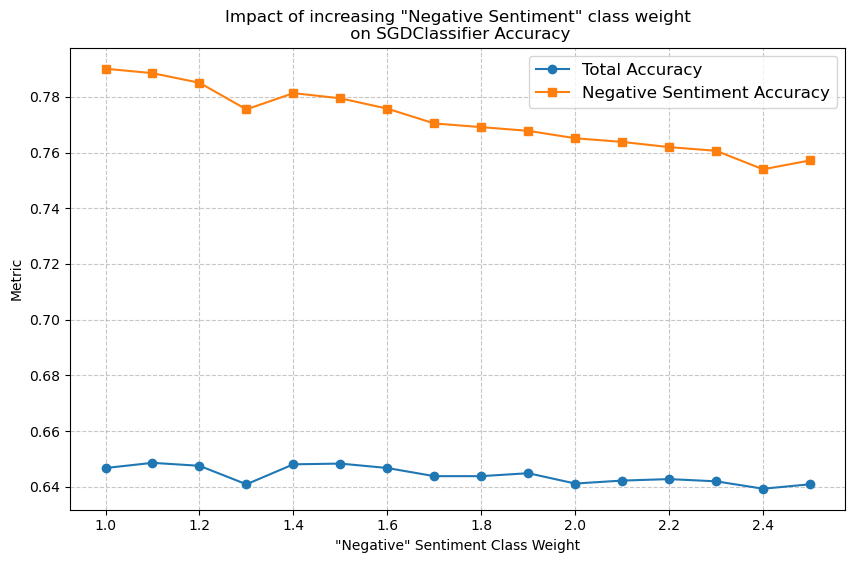

In [27]:
# Set the model to visualize
model_visualized = 'SGDClassifier'

# Create the line chart
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot each line
plt.plot(weight_range, model_accuracy_lists[model_visualized], label='Total Accuracy', marker='o')
plt.plot(weight_range, model_accuracy_negative_lists[model_visualized], label='Negative Sentiment Accuracy', marker='s')

# Clarify Plot
plt.xlabel("\"Negative\" Sentiment Class Weight")
plt.ylabel("Metric")
plt.title(f"Impact of increasing \"Negative Sentiment\" class weight\n on {model_visualized} Accuracy")
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize='large')
plt.show()

## Compare Accuracy of Multiclass Models vs Binary Models

#### Conclusion: If willing to accept distinguishing between just Negative and non-Negative sentiments, Accuracy could be increased from 65% to 79%.

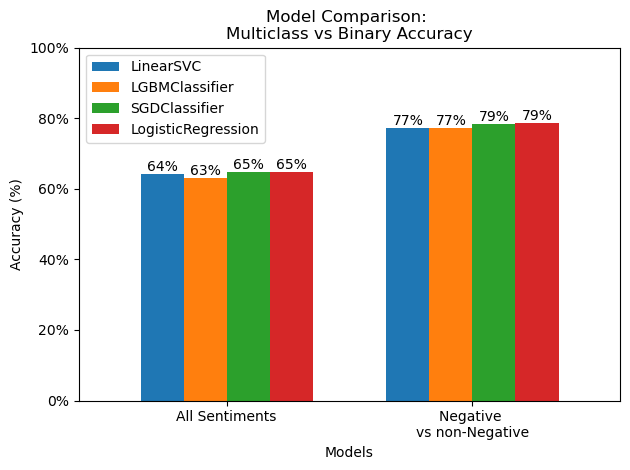

In [30]:
combined_df = pd.DataFrame({
    'All Sentiments': list(model_accuracies.values()),
    'Negative \nvs non-Negative': list(model_accuracies_negative.values())
}, index=list(model_accuracies.keys())).T
ax = combined_df.plot(kind='bar', ylim=(0,1), rot=0, xlabel='Models', ylabel='Accuracy (%)', legend=True, width=0.7)
ax.set_title('Model Comparison: \nMulticlass vs Binary Accuracy' )

# Format the y-axis as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Annotate bars with accuracy values
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()



## Display Most Important "Negative" Sentiment Roman Urdu Features

In [31]:
# Build X_train_df 
tfidf_X_train_df = pd.DataFrame(X_train_tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train[extra_features]), columns=extra_features)
X_train_df = pd.concat([tfidf_X_train_df, scaled_X_train.reset_index(drop=True)], axis=1)
X_train_df.index += 1

# Train best model on X_train_df
best_model_classifier = classification_model_dict['SGDClassifier']['clf'].fit(X_train_df, y_train)

# Derive Feature Importances
feature_importances = best_model_classifier.coef_[0] # print( "Order of classes in Model:", SGD_clf.classes_)

# Build feature_importance_df
feature_importances_df = pd.DataFrame({'Feature Name': X_train_df.columns, 'Importance': feature_importances})

# Sort and reset index of feature_importance_df
feature_importances_df.sort_values(by=['Importance'], ascending=False, inplace=True)
feature_importances_df.reset_index(drop=True, inplace=True)
feature_importances_df.index += 1



#### Display the Top 15 Negative Sentiment Features

In [32]:
def feature_importance_display(top_features_df, feature_col="Feature", score_col="Importance", lang="Roman Urdu:\n", title=None):
    """
    Display the top features and their importance scores in a horizontal bar chart.

    Parameters:
        top_features_df (pd.DataFrame): DataFrame containing the top features and their scores.
        feature_col (str): Name of the column containing feature names.
        score_col (str): Name of the column containing feature importance scores.
        lang (str): Language label for the title.
        title (str): Custom title for the plot (optional).

    """
    # Create the bar chart
    plt.barh(top_features_df[feature_col], top_features_df[score_col])
    
    # Customize plot attributes
    plt.title(f"{lang} Top {len(top_features_df)} Negative Sentiment Features", fontsize=16) if title is None else plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
        
    # Display the plot
    plt.show()

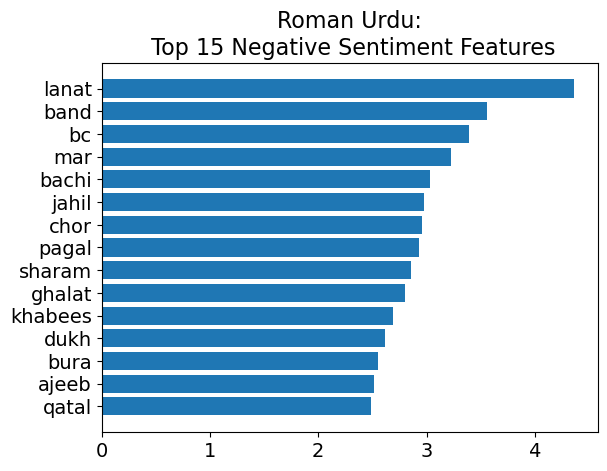

In [38]:
# Initialize Variables
n = 15
feature_importance_subdf = feature_importances_df.head(n)

# Display the top Roman Urdu Feature Importances predicting the "Negative" Sentiment
feature_importance_display(feature_importance_subdf, feature_col ="Feature Name", score_col = "Importance")

#### Display the English Translation of the most important "Negative" Sentiment Features

In [40]:
# Initialize Variables
output_column = 'feature_translation'
feature_importance_subdf[output_column] = ""

# Call openai's API to translate the texts
response = get_response(feature_importance_subdf, doc_col = ["Feature Name"], 
                        intro_context = "Translate each of the following Roman Urdu word(s) into English:", 
                        outro_context = "")

# Extract and populate the mapping dictionary
mapping = {}
response_text = response.choices[0].message.content
lines = response_text.split('\n')
for line in lines:
    parts = line.split('. ', 1)
    if len(parts) == 2:
        number, text = parts
        mapping[int(number)] = text
        
# Map the translated output to the output column
feature_importance_subdf.loc[feature_importance_subdf.index, output_column] = feature_importance_subdf.index.map(mapping)


c:\AnacondaforJoe\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\AnacondaforJoe\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


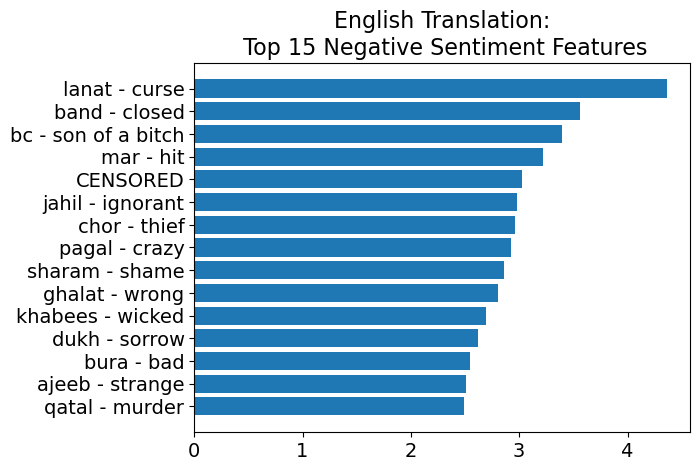

In [42]:
# Define a placeholder for censored text
CENSORED_TEXT = 'CENSORED'

# Combine translations and filter censored row
feature_importance_subdf.loc[5, 'feature_translation'] = CENSORED_TEXT

# Display the top English Translation of the Feature Importances predicting the "Negative" Sentiment
feature_importance_display(feature_importance_subdf, feature_col ="feature_translation", score_col = "Importance", lang = "English Translation:\n")



In [ ]:
# Roman Urdu Data Citation: Sharf,Zareen. (2018). Roman Urdu Data Set. UCI Machine Learning Repository. https://doi.org/10.24432/C58325.

Roman Urdu Data Citation: \
Sharf,Zareen. (2018). Roman Urdu Data Set. UCI Machine Learning Repository. https://doi.org/10.24432/C58325.